# 사용 라이브러리

In [19]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import riskfolio as rp

# 글로벌 데이터 다운로드

In [13]:
tickers =[
    'SPY', # 미국 주식
    'IEV', # 유럽 주식
    'EWJ', # 일본 주식
    'EEM', # 어머징 주식
    'TLT', # 미국 장기채
    'IEF', # 미국 중기채
    'IYR', # 미국 리츠
    'RWX', # 글로벌 리츠
    'GLD', # 금
    'DBC' # 상품
]

all_data = {}
for ticker in tickers:
    all_data[ticker] = yf.download(ticker, start='1993-01-22')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 다운 받은 데이터의 수익률 구하기

In [20]:
prices = pd.DataFrame({tic: data['Adj Close'] for tic, data in all_data.items()})
prices = prices.fillna(method='ffill') # NaN값의 경우 이전 값으로 대체해주기

rets = prices.pct_change(1).dropna() # 일간 수익률 나타내기

# 데이터 수익률간 상관관계 파악하기

<AxesSubplot:>

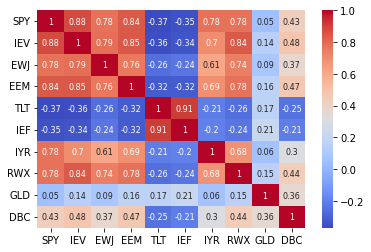

In [21]:
# 각 열들간의 상관관계 나타내기
sns.heatmap(rets.corr().round(2), annot = True, annot_kws = {'size':8}, cmap='coolwarm')

# 최대샤프지수 포트폴리오 계산하기

<AxesSubplot:title={'center':'Portfolio Composition'}>

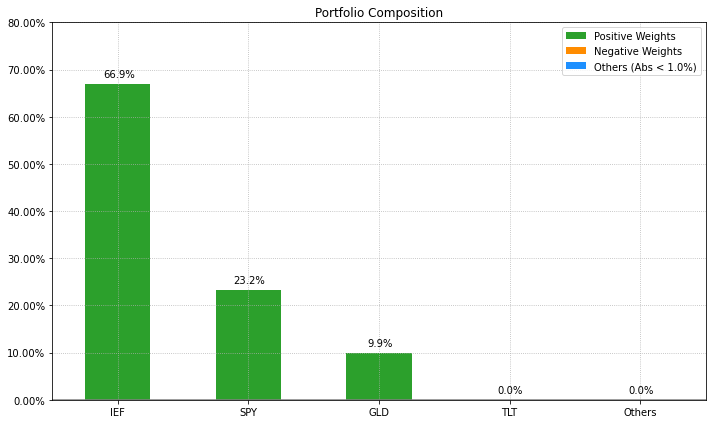

In [37]:
# 포트폴리오 객체 생성
port = rp.Portfolio(returns = rets) # 각 투자 자산별 수익률 넣어주기

# 입력값 계산
method_mu = 'hist' # 역사적 데이터를 바탕으로 기대 수익률 추정
method_cov = 'hist' # 역사적 데이터를 바탕으로 분산-공분산 행렬 추정

# 객체에 수익률 및 분산-공분산 입력
port.assets_stats(method_mu = method_mu, methode_cov = method_cov)

model = 'Classic' # 모델 입력. Classic(역사적 데이터), BL(블랙-리터만), FM(팩터 모형)
rm = 'MV' # 위험 측정 방법, MV는 표준편차를 의미
obj = 'Sharpe' # 목적함수, MinRist(최소분산), MaxRet(최대수익률, Utility(효용) or Sharpe(샤프지수)
hist = True # 역사적 데이터 사용
rf = 0 # 무위험 수익률
l = 0 # 위험 회피 계수, obj가 'Utility'일 때만 사용

# 최적화
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

round(w, 4)

rp.plot_bar(w=w)

## 최대샤프지수 : 효율적 투자선
- 각 포트폴리오의 기대수익률과 위험수준을 바탕으로, 구성할 수 있는 모든 포트폴리오를 나타낸 것

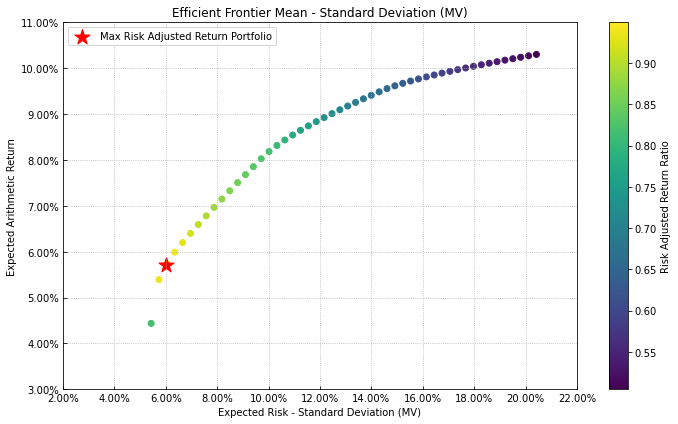

In [33]:
points = 50 # 효율적 투자선을 구성하는 샘플의 갯수
frontier = port.efficient_frontier(model=model,
                                  rm=rm,
                                  points=points,
                                  rf=rf,
                                  hist=hist)
label = "Max Risk Adjusted Return Portfolio"
mu=port.mu # 기대수익률
cov = port.cov # 분산-공분산 행렬
returns = port.returns #자산 별 수익률

ax = rp.plot_frontier(w_frontier = frontier,
                     mu=mu,
                     cov=cov,
                     returns=returns,
                     rm=rm,
                     rf=rf,
                     alpha=0.05,
                     cmap='viridis',
                     w=w,
                     label=label,
                     marker='*',
                     s=16,
                     c='r',
                     height=6,
                     width=10,
                     ax=None)

# 최소 분산
- 목적함수만 최소분산에 해당하는 'MinRisk'로 변경하면 된다.

<AxesSubplot:title={'center':'Portfolio Composition'}>

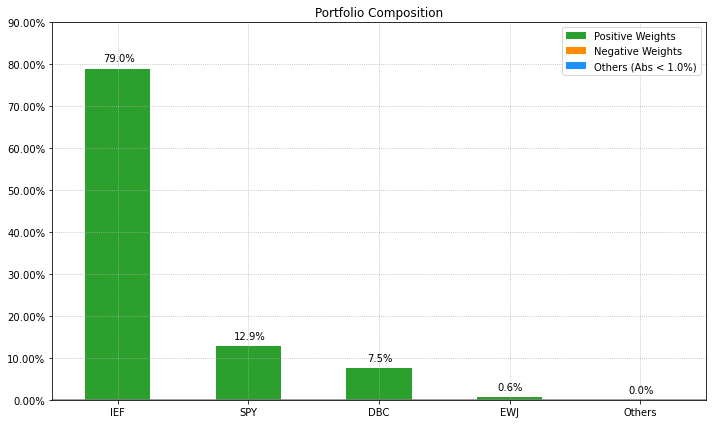

In [36]:
# 포트폴리오 객체 생성
port = rp.Portfolio(returns = rets) # 각 투자 자산별 수익률 넣어주기

# 입력값 계산
method_mu = 'hist' # 역사적 데이터를 바탕으로 기대 수익률 추정
method_cov = 'hist' # 역사적 데이터를 바탕으로 분산-공분산 행렬 추정

# 객체에 수익률 및 분산-공분산 입력
port.assets_stats(method_mu = method_mu, methode_cov = method_cov)

model = 'Classic' # 모델 입력. Classic(역사적 데이터), BL(블랙-리터만), FM(팩터 모형)
rm = 'MV' # 위험 측정 방법, MV는 표준편차를 의미
obj = 'MinRisk' # 목적함수, MinRist(최소분산), MaxRet(최대수익률, Utility(효용) or Sharpe(샤프지수)
hist = True # 역사적 데이터 사용
rf = 0 # 무위험 수익률
l = 0 # 위험 회피 계수, obj가 'Utility'일 때만 사용

# 최적화
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

round(w, 4)

rp.plot_bar(w=w)

## 최소 분산의 제약조건 추가하기
- 모든 자산에 최소 투자비중 5%, 최대 투자비중 20% 제약조건을 설정하기

In [42]:
# 제약 조건
asset_classes = {
    'Asset' : ['SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC'],
    'Class' : ['stock','stock','stock','stock','bond','bond','alternative','alternative','alternative','alternative']
}

asset_classes = pd.DataFrame(asset_classes)

constraints = {'Disabled': [False,False], # 제약 조건의 갯수
              'Type': ['All Assets', 'All Assets'], # 모든 자산(All Assets), 개별자산(Assets)
              'Set': ['',''], # 위 입력한 유니버스 중 제약조건에 해당하는 열을 의미
              'Position': ['',''], # 유니버스 중 제약조건에 해당하는 값
              'Sign': ['>=','<='], # 제약조건의 부호를 의미
              'Weight': [0.05, 0.2], # 제약조건의 값
              'Type Relative': ['',''],
              'Relative Set': ['',''],
              'Relative': ['',''],
              'Factor': ['','']}
# 즉 위 파라미터 값을 해석하면, 모든 자산의 비중이 5%이상 20% 이하로 되어야 한다는 제약조건을 설정함
constraints = pd.DataFrame(constraints)
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,>=,0.05,,,,
1,False,All Assets,,,<=,0.20,,,,


## 최소 분산의 제약조건 적용하기

UnboundLocalError: local variable 'b' referenced before assignment

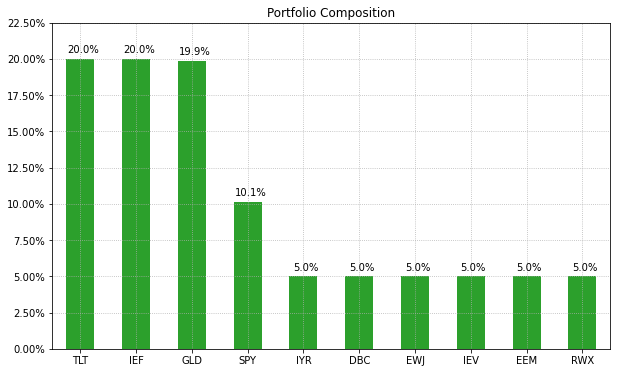

In [48]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w = port.optimization(model=model, rm=rm, obj=obj, rf= rf, l=l, hist=hist)

# round(w, 4)

rp.plot_bar(w)

# 위험균형 포트폴리오(Risk Parity Portfolio)

- 위험기여도는 특정 자산이 포트폴리오 내에서 차지하는 위험의 비중  
- 한계 위험기여도가 큰 자산도 포트폴리오 내에서 비중이 작다면, 포트폴리오 내에서 차지하는 위험의 비중은 작다.  
- 한계 위험기여도가 작은 자산일지라도 비중이 압도적으로 많다면, 포트폴리오 내에서 차지하는 위험의 비중은 크다.

따라서 특정 자산이 포트폴리오의 위험을 대부분 차지하는 문제를 막고, 모든 자산이 동일한 위험기여도를 가지는 포트폴리오가 위험균형 포트폴리오다.

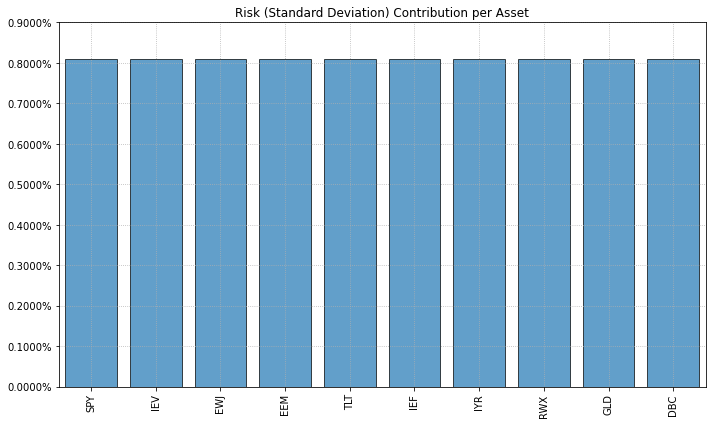

In [53]:
# 포트폴리오 객체 생성
port = rp.Portfolio(returns = rets) # 각 투자 자산별 수익률 넣어주기

# 입력값 계산
method_mu = 'hist' # 역사적 데이터를 바탕으로 기대 수익률 추정
method_cov = 'hist' # 역사적 데이터를 바탕으로 분산-공분산 행렬 추정

# 객체에 수익률 및 분산-공분산 입력
port.assets_stats(method_mu = method_mu, methode_cov = method_cov)

model = 'Classic' # 모델 입력. Classic(역사적 데이터), BL(블랙-리터만), FM(팩터 모형)
rm = 'MV' # 위험 측정 방법, MV는 표준편차를 의미
hist = True # 역사적 데이터 사용
rf = 0 # 무위험 수익률
b = None # 위험기여도 제약조건

# 최적화
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

round(w, 4)

ax = rp.plot_risk_con(w_rp,
                     cov=port.cov,
                     returns=port.returns,
                     rm=rm,
                     rf=0,
                     alpha=0.01,
                     color='tab:blue',
                     height=6,
                     width=10,
                     ax=None)

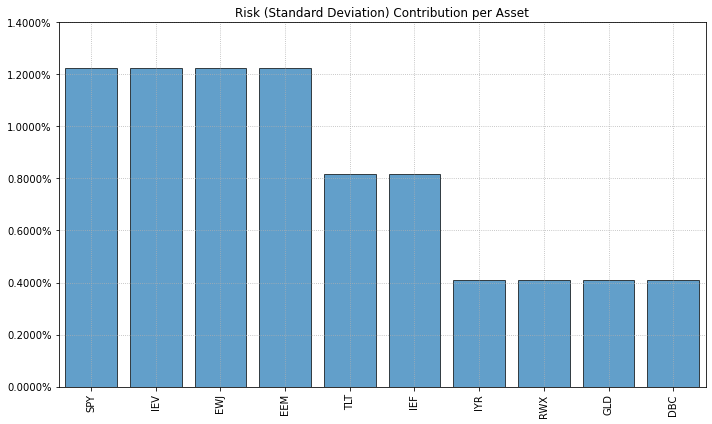

In [54]:
# 실무에서는 모든 자산의 위험기여도가 동일한 값이 아닌, 자산별로 다른 위험ㅇ=기여도를 가지는 포트폴리오를 구성해야 할 경우도 있음
# 이러한 포트폴리오를 위험 예산 포트폴리오(Risk Budget Portfolio)라고 함

# 주식은 15%, 채권은 10, 기타는 5%의 위험 비중이 있을 때
b = [0.15, 0.15, 0.15, 0.15, 0.10, 0.10, 0.05, 0.05, 0.05, 0.05]

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

round(w, 4)

ax = rp.plot_risk_con(w_rp,
                     cov=port.cov,
                     returns=port.returns,
                     rm=rm,
                     rf=0,
                     alpha=0.01,
                     color='tab:blue',
                     height=6,
                     width=10,
                     ax=None)